In [1]:
import os
from dotenv import load_dotenv 
load_dotenv()

from langchain_groq import ChatGroq
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
llm = ChatGroq(model='llama-3.1-8b-instant')
result=llm.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.009924147, 'prompt_time': 0.002002485, 'queue_time': 0.055447885, 'total_time': 0.011926632}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_3ddc9808b3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0ee93d41-2574-4d4b-b394-c2e5da6f2a3b-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [2]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from typing import Annotated,List
import operator
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict
# Graph State
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

In [5]:
# Schema for sturctured output to use in evaluation
class Feedback(BaseModel):
    grade:Literal['funny','not funny'] = Field(description="Decide if the joke is funny or not.",)
    feedback:str = Field(description="If the joke is not funny, provide feedback onhow to improve it.",)

evaluator=llm.with_structured_output(Feedback)

In [6]:
# Node
def llm_call_generator(state:State):
    """ LLM generates the joke"""
    if state.get('feedback'):
        msg = llm.invoke(f"Write a joke about {state['topic']}, but take into account the feedback: {state['feedback']}")

    else:
        msg=llm.invoke(f"Write a joke on topic {state['topic']}")
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""

    result = evaluator.invoke(f"Evaluate the joke {state['joke']}")
    return {"funny_or_not":result.grade, "feedback":result.feedback}

#Conditional edge function to route back to joke generaator or end based upon the feedback form ava;uator
def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state['funny_or_not'] == "funny":
        return "Accepted"
    elif state['funny_or_not'] == "not funny":
        return "Rejected + Feedback"




In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [8]:
# Build the workflow
optimizer_builder = StateGraph(state_schema=State)

#Add the nodde
optimizer_builder.add_node('llm_call_generator',llm_call_generator)
optimizer_builder.add_node('llm_call_evaluator',llm_call_evaluator)

#Add the edges
optimizer_builder.add_edge(START,'llm_call_generator')
optimizer_builder.add_edge('llm_call_generator','llm_call_evaluator')
optimizer_builder.add_conditional_edges(
    'llm_call_evaluator',route_joke, {"Accepted":END, "Rejected + Feedback":"llm_call_generator"},
)

#Compile the workflow
optimizer_workflow = optimizer_builder.compile()

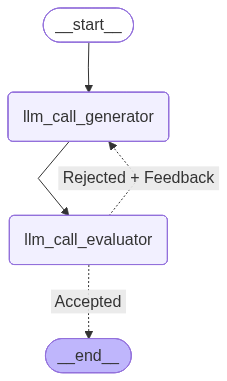

In [9]:
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [16]:
result = optimizer_workflow.invoke({'topic':"Generative AI"})
print(result['joke'])

Why did the Generative AI go to therapy?

Because it had a lot of "generated" anxiety and was struggling to "produce" a positive self-image.
